In [1]:
path_data = '../../data/'

import numpy as np
import pandas as pd
import math
import scipy.stats as stats

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [2]:
def standard_units(x):
    return (x - np.mean(x))/np.std(x)

# Rows of Tables
Now that we have a qualitative understanding of nearest neighbor classification, it's time to implement our classifier.

Until this chapter, we have worked mostly with single columns of tables. But now we have to see whether one *individual* is "close" to another. Data for individuals are contained in *rows* of tables.

So let's start by taking a closer look at rows.

Here is the original table `ckd` containing data on patients who were tested for chronic kidney disease.

In [3]:
ckd = pd.read_csv(path_data + 'ckd.csv').rename(columns={'Blood Glucose Random': 'Glucose'})
ckd.head()

Age  Blood Pressure  Specific Gravity  Albumin  Sugar Red Blood Cells  \
0   48              70             1.005        4      0          normal   
1   53              90             1.020        2      0        abnormal   
2   63              70             1.010        3      0        abnormal   
3   68              80             1.010        3      2          normal   
4   61              80             1.015        2      0        abnormal   

   Pus Cell Pus Cell clumps    Bacteria  Glucose  ...  Packed Cell Volume  \
0  abnormal         present  notpresent      117  ...                  32   
1  abnormal         present  notpresent       70  ...                  29   
2  abnormal         present  notpresent      380  ...                  32   
3  abnormal         present     present      157  ...                  16   
4  abnormal      notpresent  notpresent      173  ...                  24   

   White Blood Cell Count  Red Blood Cell Count  Hypertension  \
0                    6700                   3.9           yes   
1                   12100                   3.7           yes   
2                    4500                   3.8           yes   
3                   11000                   2.6           yes   
4                    9200                   3.2           yes   

   Diabetes Mellitus  Coronary Artery Disease  Appetite  Pedal Edema Anemia  \
0                 no                       no      poor          yes    yes   
1                yes                       no      poor           no    yes   
2                yes                       no      poor          yes     no   
3                yes                      yes      poor          yes     no   
4                yes                      yes      poor          yes    yes   

  Class  
0     1  
1     1  
2     1  
3     1  
4     1  

[5 rows x 25 columns]

The data corresponding to the first patient is in row 0 of the table, consistent with Python's indexing system. The Table method `row` accesses the row by taking the index of the row as its argument:

In [4]:
ckd.iloc[0]

Age                                48
Blood Pressure                     70
Specific Gravity                1.005
Albumin                             4
Sugar                               0
Red Blood Cells                normal
Pus Cell                     abnormal
Pus Cell clumps               present
Bacteria                   notpresent
Glucose                           117
Blood Urea                         56
Serum Creatinine                  3.8
Sodium                            111
Potassium                         2.5
Hemoglobin                       11.2
Packed Cell Volume                 32
White Blood Cell Count           6700
Red Blood Cell Count              3.9
Hypertension                      yes
Diabetes Mellitus                  no
Coronary Artery Disease            no
Appetite                         poor
Pedal Edema                       yes
Anemia                            yes
Class                               1
Name: 0, dtype: object

## Or, as an array

In [5]:
np.array(ckd.loc[0])

array([48, 70, 1.005, 4, 0, 'normal', 'abnormal', 'present', 'notpresent',
       117, 56, 3.8, 111, 2.5, 11.2, 32, 6700, 3.9, 'yes', 'no', 'no',
       'poor', 'yes', 'yes', 1], dtype=object)

Rows have their very own data type: they are *row objects*. Notice how when using the pandas `df.loc[row]` the display shows not only the values in the row but also the labels of the corresponding columns.

Rows are in general **not arrays**, as their elements can be of different types. For example, some of the elements of the row above are strings (like `'abnormal'`) and some are numerical.

However, rows share some characteristics with arrays.  You can use `.iloc[row:column]` to access a particular element of a row. For example, to access the Albumin level of Patient 0, we can look at the labels in the printout of the row above to find that it's the column 'Albumin' is column index 3 i.e. `.iloc[row_number,3:`.

In [6]:
ckd.iloc[0,3]

4

In [7]:
type(ckd['Class'].iloc[0])

numpy.int64

## Converting Rows to Arrays (When Possible)
Rows whose elements are all numerical (or all strings) can be converted to arrays.  Converting a row to an array gives us access to arithmetic operations and other nice NumPy functions, so it is often useful.

Recall that in the previous section we tried to classify the patients as 'CKD' or 'not CKD', based on two attributes `Hemoglobin` and `Glucose`, both measured in standard units. 

In [8]:
ckd = pd.DataFrame(
    {'Hemoglobin':standard_units(ckd['Hemoglobin']),
    'Glucose':standard_units(ckd['Glucose']),  
    'Class':ckd['Class']}
)

color_table = pd.DataFrame(
    {'Class':np.array([1, 0]),
    'Color':np.array(['darkblue', 'gold'])}
)

ckd = pd.merge(ckd, color_table, on='Class')

ckd

Hemoglobin   Glucose  Class     Color
0     -0.865744 -0.221549      1  darkblue
1     -1.457446 -0.947597      1  darkblue
2     -1.004968  3.841231      1  darkblue
3     -2.814879  0.396364      1  darkblue
4     -2.083954  0.643529      1  darkblue
..          ...       ...    ...       ...
153    0.700526  0.133751      0      gold
154    0.978974 -0.870358      0      gold
155    0.735332 -0.484162      0      gold
156    0.178436 -0.267893      0      gold
157    0.735332 -0.005280      0      gold

[158 rows x 4 columns]

Here is a scatter plot of the two attributes, along with a red point corresponding to Alice, a new patient. Her value of hemoglobin is 0 (that is, at the average) and glucose 1.1 (that is, 1.1 SDs above average).

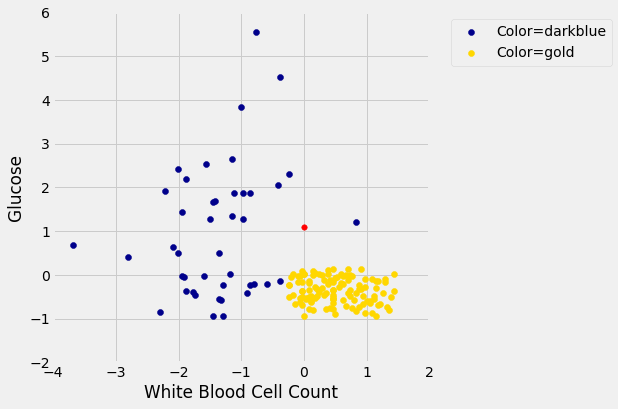

In [9]:
alice = np.array([0, 1.1])

ckd_darkblue = ckd[ckd['Color'] == 'darkblue']
ckd_gold = ckd[ckd['Color'] == 'gold']


fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(ckd_darkblue['Hemoglobin'], 
           ckd_darkblue['Glucose'],  
           label='Color=darkblue', 
           color='darkblue')

ax.scatter(ckd_gold['Hemoglobin'], 
           ckd_gold['Glucose'],  
           label='Color=gold', 
           color='gold')

ax.scatter(alice[0], 
           alice[1],   
           color='red', 
           s=30)

x_label = 'White Blood Cell Count'

y_label = 'Glucose'

y_vals = ax.get_yticks()

plt.ylabel(y_label)

ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.xlabel(x_label)

plt.xlim(-4, 2)
plt.ylim(-2, 6);

plt.show()

To find the distance between Alice's point and any of the other points, we only need the values of the attributes:

In [10]:
ckd_attributes = ckd[['Hemoglobin', 'Glucose']]

In [11]:
ckd_attributes

Hemoglobin   Glucose
0     -0.865744 -0.221549
1     -1.457446 -0.947597
2     -1.004968  3.841231
3     -2.814879  0.396364
4     -2.083954  0.643529
..          ...       ...
153    0.700526  0.133751
154    0.978974 -0.870358
155    0.735332 -0.484162
156    0.178436 -0.267893
157    0.735332 -0.005280

[158 rows x 2 columns]

Each row consists of the coordinates of one point in our training sample. **Because the rows now consist only of numerical values**, it is possible to convert them to arrays.  For this, we use the function `np.array`, which converts any kind of sequential object, like a row, to an array. (Our old friend `make_array` is for *creating* arrays, not for *converting* other kinds of sequences to arrays.)

In [12]:
ckd_attributes.iloc[3]

Hemoglobin   -2.814879
Glucose       0.396364
Name: 3, dtype: float64

In [13]:
np.array(ckd_attributes.iloc[3])

array([-2.81487943,  0.39636401])

This is very handy because we can now use array operations on the data in each row.

## Distance Between Points When There are Two Attributes
The main calculation we need to do is to find the distance between Alice's point and any other point. For this, the first thing we need is a way to compute the distance between any pair of points. 

How do we do this?  In 2-dimensional space, it's pretty easy.  If we have a point at coordinates $(x_0,y_0)$ and another at $(x_1,y_1)$, the distance between them is

$$
D = \sqrt{(x_0-x_1)^2 + (y_0-y_1)^2}
$$

(Where did this come from?  It comes from the Pythogorean theorem: we have a right triangle with side lengths $x_0-x_1$ and $y_0-y_1$, and we want to find the length of the hypotenuse.)



In the next section we'll see that this formula has a straightforward extension when there are more than two attributes. For now, let's use the formula and array operations to find the distance between Alice and the patient in Row 3.

In [14]:
patient3 = np.array(ckd_attributes.iloc[3])
alice, patient3

(array([0. , 1.1]), array([-2.81487943,  0.39636401]))

In [15]:
distance = np.sqrt(np.sum((alice - patient3)**2))
distance

2.9014909651272616

We're going to need the distance between Alice and a bunch of points, so let's write a function called `distance` that computes the distance between any pair of points. The function will take two arrays, each containing the $(x, y)$ coordinates of a point.  (Remember, those are really the Hemoglobin and Glucose levels of a patient.)

In [16]:
def distance(point1, point2):
    """Returns the Euclidean distance between point1 and point2.
    
    Each argument is an array containing the coordinates of a point."""
    return np.sqrt(np.sum((point1 - point2)**2))

In [17]:
distance(alice, patient3)

2.9014909651272616

We have begun to build our classifier: the `distance` function is the first building block. Now let's work on the next piece.

### Using `apply` on an Entire Row
Recall that if you want to apply a function to each element of a column of a table, one way to do that is by the call `table_name.apply(function_name, column_label)`. This evaluates to an array consisting of the values of the function when we call it on each element of the column. So each entry of the array is based on the corresponding row of the table.

If you use `apply` without specifying a column label, then the entire row is passed to the function. Let's see how this works on a very small table `t` containing the information about the first five patients in the training sample.

In [18]:
t = ckd_attributes.take(np.arange(5))
t

Hemoglobin   Glucose
0   -0.865744 -0.221549
1   -1.457446 -0.947597
2   -1.004968  3.841231
3   -2.814879  0.396364
4   -2.083954  0.643529

Just as an example, suppose that for each patient we want to know how unusual their most unusual attribute is.  Concretely, if a patient's hemoglobin level is further from the average than her glucose level, we want to know how far it is from the average.  If her glucose level is further from the average than her hemoglobin level, we want to know how far that is from the average instead.

That's the same as taking the maximum of the absolute values of the two quantities. To do this for a particular row, we can convert the row to an array and use array operations.

In [19]:
def max_abs(row):
    return np.max(np.abs(np.array(row)))

In [20]:
max_abs(t.iloc[0])

0.8657439478031919

And now we can apply `max_abs` to each row of the table `t`:

In [21]:
t.apply(max_abs, axis=1)

0    0.865744
1    1.457446
2    3.841231
3    2.814879
4    2.083954
dtype: float64

This way of using `apply` will help us create the next building block of our classifier.

## Alice's $k$ Nearest Neighbors
If we want to classify Alice using a k-nearest neighbor classifier, we have to identify her $k$ nearest neighbors. What are the steps in this process? Suppose $k = 5$. Then the steps are:
- **Step 1.** Find the distance between Alice and each point in the training sample.
- **Step 2.** Sort the data table in increasing order of the distances.
- **Step 3.** Take the top 5 rows of the sorted table.

Steps 2 and 3 seem straightforward, provided we have the distances. So let's focus on Step 1.

Here's Alice:

In [22]:
alice

array([0. , 1.1])

What we need is a function that finds the distance between Alice and another point whose coordinates are contained in a row. The function `distance` returns the distance between any two points whose coordinates are in arrays. We can use that to define `distance_from_alice`, which takes a row as its argument and returns the distance between that row and Alice.

In [23]:
def distance_from_alice(row):
    """Returns distance between Alice and a row of the attributes table"""
    return distance(alice, np.array([row]))

In [24]:
distance_from_alice(ckd_attributes.iloc[3])

2.9014909651272616

Now we can `apply` the function `distance_from_alice` to each row of `ckd_attributes`, and augment the table `ckd` with the distances. Step 1 is complete!

In [25]:
distances = ckd_attributes.apply(distance_from_alice, axis=1)
ckd_with_distances = ckd.copy()
ckd_with_distances['Distance from Alice'] = distances

In [26]:
ckd_with_distances

Hemoglobin   Glucose  Class     Color  Distance from Alice
0     -0.865744 -0.221549      1  darkblue             1.579875
1     -1.457446 -0.947597      1  darkblue             2.513325
2     -1.004968  3.841231      1  darkblue             2.919641
3     -2.814879  0.396364      1  darkblue             2.901491
4     -2.083954  0.643529      1  darkblue             2.133361
..          ...       ...    ...       ...                  ...
153    0.700526  0.133751      0      gold             1.193471
154    0.978974 -0.870358      0      gold             2.200159
155    0.735332 -0.484162      0      gold             1.746506
156    0.178436 -0.267893      0      gold             1.379482
157    0.735332 -0.005280      0      gold             1.327537

[158 rows x 5 columns]

For Step 2, let's sort the table in increasing order of distance:

In [27]:
sorted_by_distance = ckd_with_distances.sort_values(by=['Distance from Alice'])
sorted_by_distance

Hemoglobin   Glucose  Class     Color  Distance from Alice
14     0.839750  1.215099      1  darkblue             0.847601
35    -0.970162  1.276890      1  darkblue             0.986156
84    -0.030400  0.087407      0      gold             1.013049
152    0.143630  0.087407      0      gold             1.022728
6     -0.413266  2.049282      1  darkblue             1.035338
..          ...       ...    ...       ...                  ...
2     -1.004968  3.841231      1  darkblue             2.919641
12    -2.292790 -0.854910      1  darkblue             3.013065
41    -0.378460  4.520935      1  darkblue             3.441806
42    -3.685029  0.689873      1  darkblue             3.707782
36    -0.761326  5.540492      1  darkblue             4.505285

[158 rows x 5 columns]

Step 3: The top 5 rows correspond to Alice's 5 nearest neighbors; you can replace 5 by any other positive integer.

In [28]:
alice_5_nearest_neighbors = sorted_by_distance.take(np.arange(5))
alice_5_nearest_neighbors

Hemoglobin   Glucose  Class     Color  Distance from Alice
14     0.839750  1.215099      1  darkblue             0.847601
35    -0.970162  1.276890      1  darkblue             0.986156
84    -0.030400  0.087407      0      gold             1.013049
152    0.143630  0.087407      0      gold             1.022728
6     -0.413266  2.049282      1  darkblue             1.035338

Three of Alice's five nearest neighbors are blue points and two are gold. So a 5-nearest neighbor classifier would classify Alice as blue: it would predict that Alice has chronic kidney disease.

The graph below zooms in on Alice and her five nearest neighbors. The two gold ones just inside the circle directly below the red point. The classifier says Alice is more like the three blue ones around her.

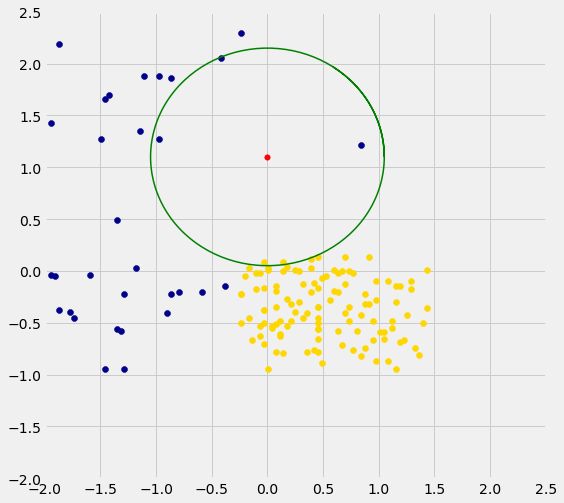

In [29]:
radius = sorted_by_distance['Distance from Alice'].iloc[4]+0.014
theta = np.arange(0, 2*np.pi+1, 2*np.pi/200)

alice = np.array([0, 1.1])

ckd_darkblue = ckd[ckd['Color'] == 'darkblue']
ckd_gold = ckd[ckd['Color'] == 'gold']

fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(ckd_darkblue['Hemoglobin'], 
           ckd_darkblue['Glucose'],   
           color='darkblue')

ax.scatter(ckd_gold['Hemoglobin'], 
           ckd_gold['Glucose'],   
           color='gold')

ax.scatter(alice[0], 
           alice[1],   
           color='red', 
           s=30)

ax.plot(radius*np.cos(theta)+alice.item(0), radius*np.sin(theta)+alice.item(1), color='g', lw=1.5, zorder=10);

plt.xlim(-2, 2.5)
plt.ylim(-2, 2.5);

plt.show()

We are well on our way to implementing our k-nearest neighbor classifier. In the next two sections we will put it together and assess its accuracy.